In [4]:
import numpy as np
import pandas as pd
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
%matplotlib inline

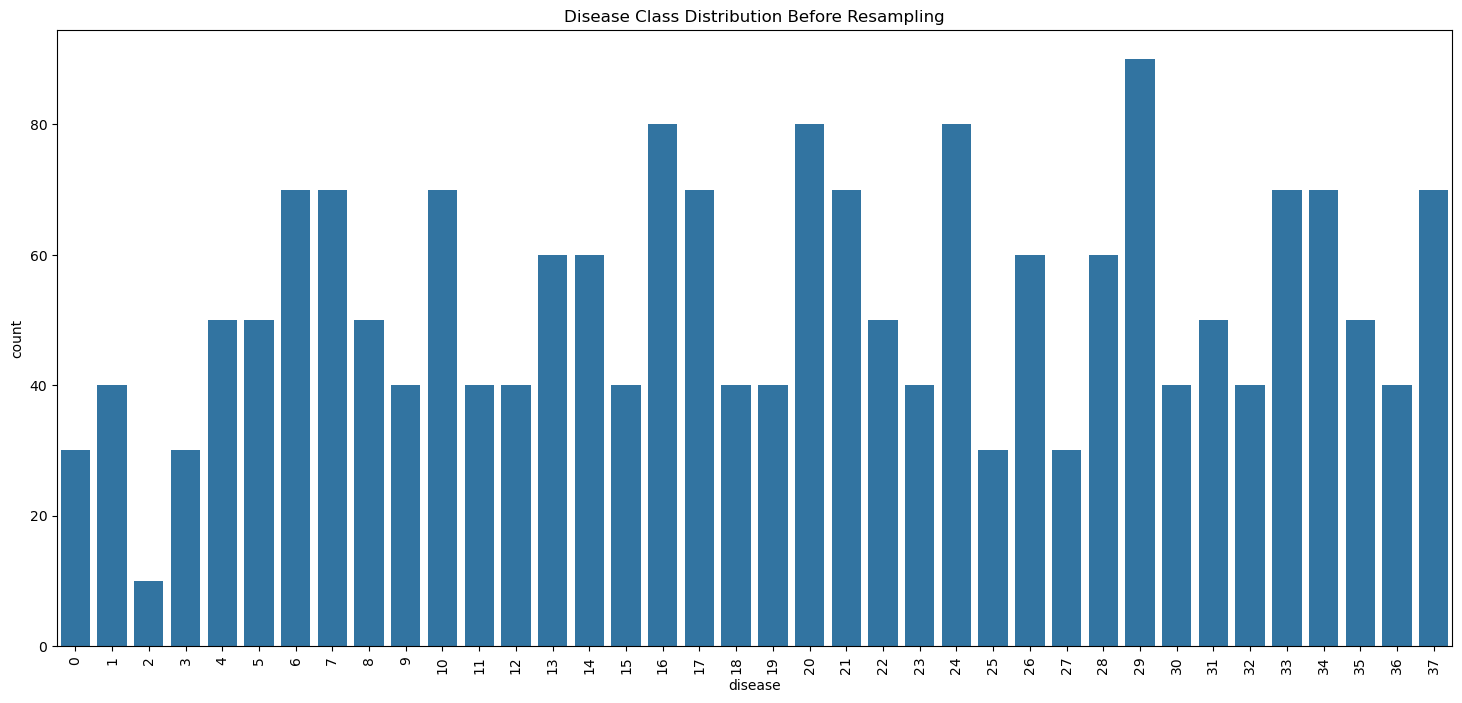

In [3]:
data = pd.read_csv('improved_disease_dataset.csv')

encoder = LabelEncoder()
data["disease"] = encoder.fit_transform(data["disease"])

X = data.iloc[:, :-1]
y = data.iloc[:, -1]

plt.figure(figsize=(18, 8))
sns.countplot(x=y)
plt.title("Disease Class Distribution Before Resampling")
plt.xticks(rotation=90)
plt.show()

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [4]:
if 'gender' in X_resampled.columns:
    le = LabelEncoder()
    X_resampled['gender'] = le.fit_transform(X_resampled['gender'])

X_resampled = X_resampled.fillna(0)

if len(y_resampled.shape) > 1:
    y_resampled = y_resampled.values.ravel()

models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC()
}

cv_scoring = 'accuracy'  
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    try:
        scores = cross_val_score(
            model,
            X_resampled,
            y_resampled,
            cv=stratified_kfold,
            scoring=cv_scoring,
            n_jobs=-1,
            error_score='raise' 
        )
        print("=" * 50)
        print(f"Model: {model_name}")
        print(f"Scores: {scores}")
        print(f"Mean Accuracy: {scores.mean():.4f}")
    except Exception as e:
        print("=" * 50)
        print(f"Model: {model_name} failed with error:")
        print(e)

Model: Decision Tree
Scores: [0.5497076  0.54532164 0.53508772 0.53654971 0.5248538 ]
Mean Accuracy: 0.5383
Model: Random Forest
Scores: [0.56432749 0.54678363 0.54385965 0.53947368 0.53216374]
Mean Accuracy: 0.5453
Model: SVM
Scores: [0.51315789 0.51169591 0.49707602 0.48245614 0.49561404]
Mean Accuracy: 0.5000


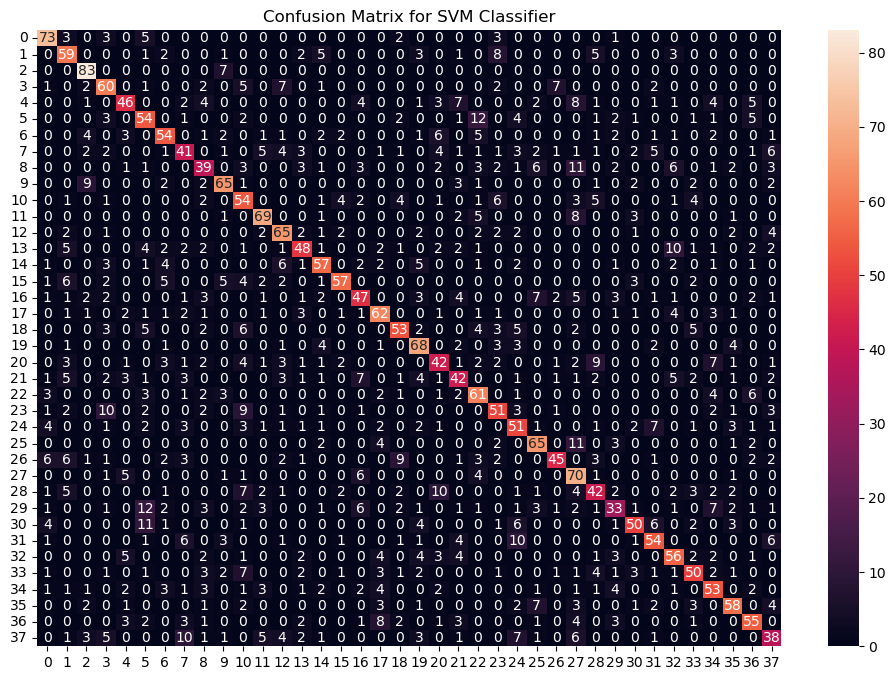

SVM Accuracy: 60.53%


In [5]:
svm_model = SVC()
svm_model.fit(X_resampled, y_resampled)
svm_preds = svm_model.predict(X_resampled)

cf_matrix_svm = confusion_matrix(y_resampled, svm_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(cf_matrix_svm, annot=True, fmt="d")
plt.title("Confusion Matrix for SVM Classifier")
plt.show()

print(f"SVM Accuracy: {accuracy_score(y_resampled, svm_preds) * 100:.2f}%")

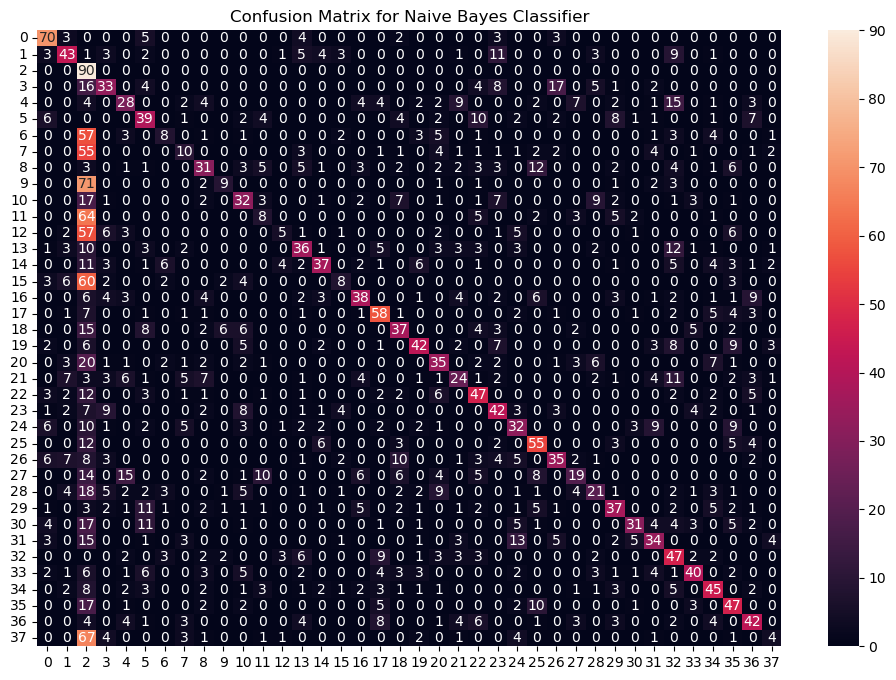

Naive Bayes Accuracy: 37.98%


In [6]:
nb_model = GaussianNB()
nb_model.fit(X_resampled, y_resampled)
nb_preds = nb_model.predict(X_resampled)

cf_matrix_nb = confusion_matrix(y_resampled, nb_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(cf_matrix_nb, annot=True, fmt="d")
plt.title("Confusion Matrix for Naive Bayes Classifier")
plt.show()

print(f"Naive Bayes Accuracy: {accuracy_score(y_resampled, nb_preds) * 100:.2f}%")

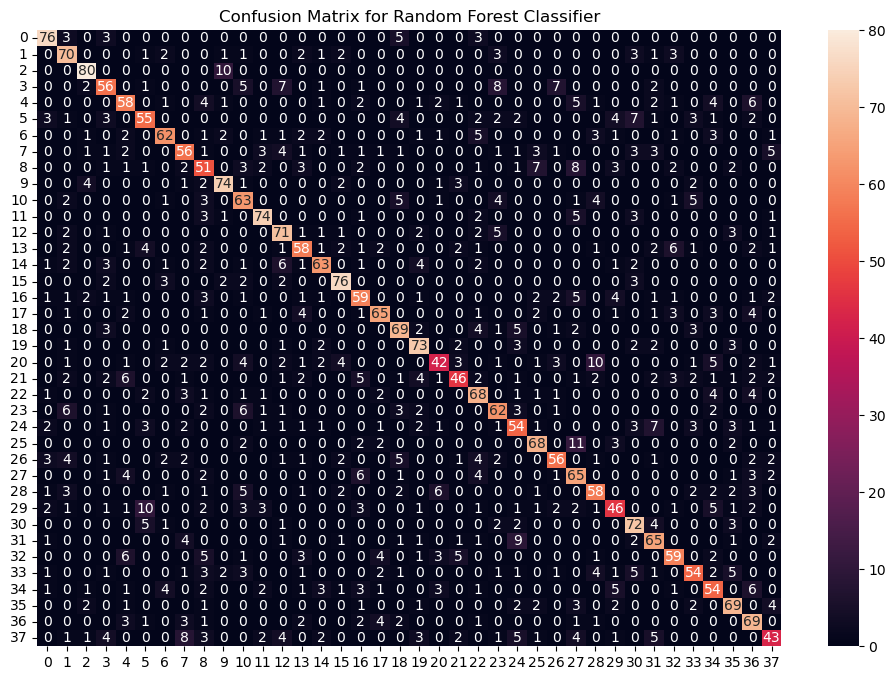

Random Forest Accuracy: 68.98%


In [7]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_resampled, y_resampled)
rf_preds = rf_model.predict(X_resampled)

cf_matrix_rf = confusion_matrix(y_resampled, rf_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(cf_matrix_rf, annot=True, fmt="d")
plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()

print(f"Random Forest Accuracy: {accuracy_score(y_resampled, rf_preds) * 100:.2f}%")

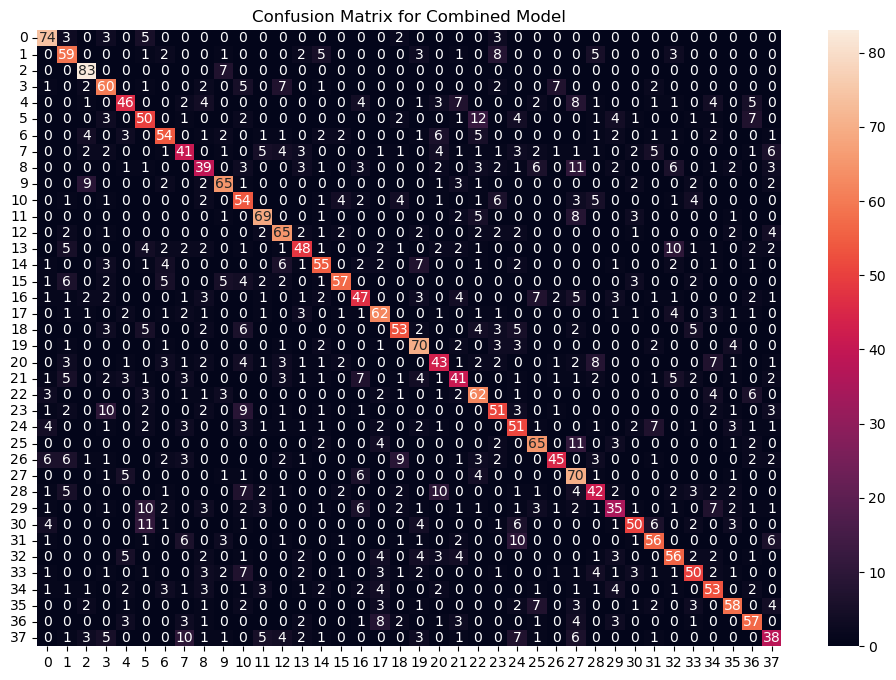

Combined Model Accuracy: 60.64%


In [8]:
from statistics import mode

final_preds = [mode([i, j, k]) for i, j, k in zip(svm_preds, nb_preds, rf_preds)]

cf_matrix_combined = confusion_matrix(y_resampled, final_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(cf_matrix_combined, annot=True, fmt="d")
plt.title("Confusion Matrix for Combined Model")
plt.show()

print(f"Combined Model Accuracy: {accuracy_score(y_resampled, final_preds) * 100:.2f}%")

In [9]:
symptoms = X.columns.values
symptom_index = {symptom: idx for idx, symptom in enumerate(symptoms)}

def predict_disease(input_symptoms):
    input_symptoms = input_symptoms.split(",")
    input_data = [0] * len(symptom_index)
    
    for symptom in input_symptoms:
        if symptom in symptom_index:
            input_data[symptom_index[symptom]] = 1

    input_df = pd.DataFrame([input_data], columns=symptoms)

    rf_pred = encoder.classes_[rf_model.predict(input_df)[0]]
    nb_pred = encoder.classes_[nb_model.predict(input_df)[0]]
    svm_pred = encoder.classes_[svm_model.predict(input_df)[0]]

    final_pred = mode([rf_pred, nb_pred, svm_pred])
    
    return {
        "Random Forest Prediction": rf_pred,
        "Naive Bayes Prediction": nb_pred,
        "SVM Prediction": svm_pred,
        "Final Prediction": final_pred
    }

print(predict_disease("skin_rash,fever,headache"))

{'Random Forest Prediction': 'Peptic ulcer disease', 'Naive Bayes Prediction': 'Impetigo', 'SVM Prediction': 'Peptic ulcer disease', 'Final Prediction': 'Peptic ulcer disease'}
